# Importing libraries

In [3]:
import os
import cv2
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import keras
import tensorflow

from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG19
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout, BatchNormalization, Activation

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, f1_score

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Defining data paths

In [5]:
train_path = "/content/drive/MyDrive/dataset80-20/training"

val_path ="/content/drive/MyDrive/dataset80-20/testing"

# Converting image to pixels

normal


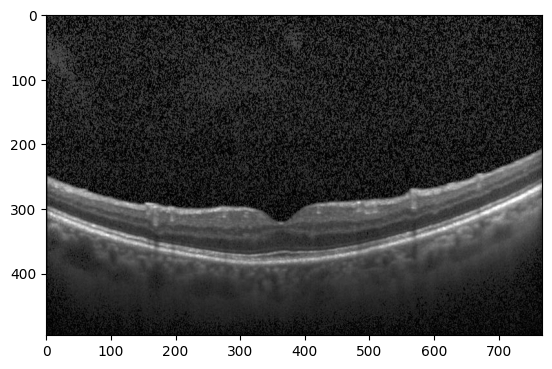

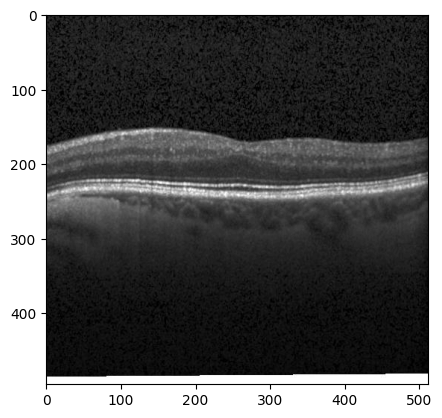

cnv


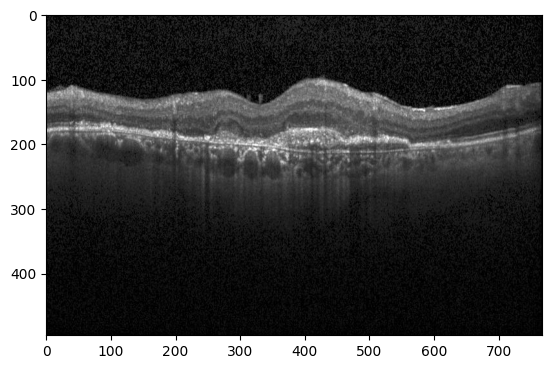

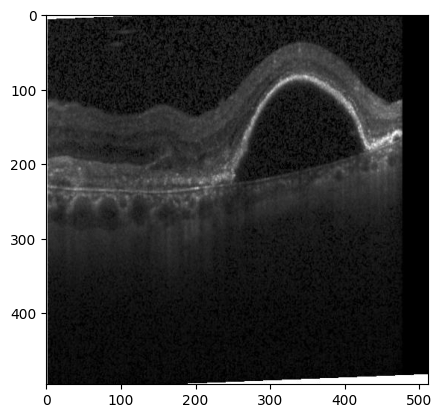

In [6]:
for folder in os.listdir(train_path):
    sub_path = train_path + "/" + folder

    print(folder)
    for i in range(2):
        temp_path = os.listdir(sub_path)[i]
        temp_path = sub_path + "/" + temp_path
        img = mpimg.imread(temp_path, cv2.IMREAD_GRAYSCALE)
        imgplot = plt.imshow(img, cmap='gray')
        plt.show()

In [7]:
def imagearray(path, size):
    data = []
    for folder in os.listdir(path):
        sub_path=path+"/"+folder

        for img in os.listdir(sub_path):
            image_path=sub_path+"/"+img
            img_arr=cv2.imread(image_path)
            img_arr=cv2.resize(img_arr, size)
            data.append(img_arr)

    return data

In [8]:
size = (250,250)

train = imagearray(train_path, size)

val = imagearray(val_path, size)

# Normalization

In [9]:
x_train = np.array(train)

x_val = np.array(val)

In [ ]:
x_train = x_train/255.0

x_val = x_val/255.0

# Defining target variables

In [ ]:
def data_class(data_path, size, class_mode):
    datagen = ImageDataGenerator(rescale = 1./255)
    classes = datagen.flow_from_directory(data_path,
                                          target_size = size,
                                          batch_size = 32,
                                          class_mode = class_mode)
    return classes

In [ ]:
train_class = data_class(train_path, size, 'sparse')

val_class = data_class(val_path, size, 'sparse')

In [ ]:
y_train = train_class.classes

y_val = val_class.classes

In [ ]:
train_class.class_indices

In [ ]:
y_train.shape,y_val.shape

# VGG19 Model

In [ ]:
vgg = VGG19(input_shape = (224, 224, 3), weights = 'imagenet', include_top = False)

In [ ]:
for layer in vgg.layers:
    layer.trainable = False

x = Flatten()(vgg.output)
prediction = Dense(2, activation='softmax')(x)

model = Model(inputs=vgg.input, outputs=prediction)
model.summary()
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer="adam",
  metrics=['accuracy']
)

In [ ]:
plot_model(model=model, show_shapes=True)

In [ ]:
early_stop = EarlyStopping(monitor = 'val_loss', mode='min', verbose = 1, patience = 5)

In [ ]:
history = model.fit(x_train, y_train, validation_data = (x_val, y_val), epochs = 20, callbacks=[early_stop], batch_size = 30,
                    shuffle=True)

In [ ]:
model.save('/content/drive/MyDrive/models 60-40/model-vggnet19-60-40.h5')

# Visualization

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy')
plt.show()

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title('Loss')
plt.show()

# Model Evaluation

In [ ]:
from matplotlib.pyplot import imread
from matplotlib.pyplot import imshow
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras.applications.imagenet_utils import preprocess_input


img_path = "/content/drive/MyDrive/cnv sample/CNV-732516-4.jpeg"
#img_path="/content/drive/MyDrive/normal sample/NORMAL-508852-2.jpeg"

#img = image.load_img(img_path, target_size=(224, 224))
#x = img.img_to_array(img)

img = cv2.imread(img_path)
img = cv2.resize(img, (224, 224))

x = np.expand_dims(img, axis=0)
x = preprocess_input(x)

print('Input image shape:', x.shape)

my_image = imread(img_path)
imshow(my_image)

In [ ]:
preds=model.predict(x)
preds

In [ ]:
print(preds)
if preds[0][0]>preds[0][1]:
    prediction="cnv"


else:
    prediction="normal"
print(prediction)

# Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, f1_score

# Predict on validation data
y_val_pred = model.predict(x_val)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)

# Confusion Matrix
confusion = confusion_matrix(y_val, y_val_pred_classes)

# Classification Report
classification_rep = classification_report(y_val, y_val_pred_classes, target_names=train_class.class_indices)

# Accuracy Score
accuracy = accuracy_score(y_val, y_val_pred_classes)

# Recall Score
recall = recall_score(y_val, y_val_pred_classes)

# Precision Score
precision = precision_score(y_val, y_val_pred_classes)

# F1-Score
f1 = f1_score(y_val, y_val_pred_classes)

print("Confusion Matrix:")
print(confusion)

print("\nClassification Report:")
print(classification_rep)

print("\nAccuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F1-Score:", f1)

# Saving Model

In [1]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, auc
import numpy as np

# ...

# Load your saved model
model_path = '/content/drive/MyDrive/models 80-20/model-vggnet19-80-20.h5'
loaded_model = keras.models.load_model(model_path)

# ...

# Predict probabilities on the validation dataset
y_val_pred = loaded_model.predict(x_val)
y_val_probs = y_val_pred[:, 1]  # Assuming binary classification, get probabilities of class '1'

# Calculate ROC curve and AUC
fpr, tpr, _ = roc_curve(y_val, y_val_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


NameError: ignored